### TODO:

1. Decide on number of clusters (5??)  
2. Create training set, labelling datapoints manually  
3. Use ML model to predict labels.  
Classification, multioutput;  
Models to use: ??  
Use ensemble learning??  

CV search for optimal results

4. Build model into a pipeline 
 

In [1]:
print('imports and options')
import pandas as pd
import datetime as dt
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
# pd.set_option('display.max_colwidth',20) #change this to increse width cutoff limit
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 20)
pd.set_option('display.width', 1000)

plt.rcParams['figure.figsize'] = [5,5]#[20, 10]
# plt.rcParams['axes.facecolor'] = 'black'

imports and options


In [2]:
print('Load file')
by_good = pd.read_excel('by_name.xls',skiprows=list(range(8)),header = 0,na_values=[' ']).fillna(0)
by_good = by_good.drop(columns = ['Unnamed: 1','Unnamed: 2'])
by_good = by_good.rename(columns={'Unnamed: 0':'name','единица':'amt',
                                  'Сумма':'in','Сумма.1':'Out','Процент':'Prof %','Сумма.2':'Profit'})

Load file


In [3]:
print('Deal with anomalies')
drop = [0,3261] 
# # Profit <=0
drop += [769, 1082, 113, 332, 333, 1531, 2133, 2401, 799, 1804, 1519, 778, 1338, 2391, 1518, 1568, 2567, 707, 787, 385, 1344, 2665,
         454, 2717, 2755, 2543, 3236, 85, 2561, 132, 2803, 3254, 1828, 97, 337, 1609, 2552, 2500, 3211, 1984, 84, 1968, 2790, 875, 
         1021, 2489, 1469, 1900, 2437, 2503, 2856, 2431, 2537, 2737, 2950, 2928, 1118, 2559, 719, 33, 2930, 2929, 2323, 26, 2013, 
         1965, 1812, 54, 68, 2859, 3227, 1450, 80, 703, 602, 1253, 1437, 771, 2353, 53, 1898, 3248, 2130, 953, 768, 1705, 143, 1934, 
         1292, 206, 1107, 877, 293, 1037, 977]
# Unreal profit
drop+= [3170, 821, 90, 730, 1682, 1538, 1539, 1541, 2122, 62, 2299, 694, 819, 4, 1, 2,1485]

by_good.loc[sorted(drop),:]

df = by_good.drop(drop)
df = df.drop(columns = ['in','Out'])
df = df.reset_index(drop=True)


Deal with anomalies


In [11]:
print('Feature extraction and pipeline')
'''
Try differents scaling approach
CountVectorizer parameters??
Stop words??
feature selection: nums?, 
'''
# profit per unit
df['PPU'] = df['Profit']/df['amt'] 

# pipeline
from sklearn.compose import ColumnTransformer

from sklearn.feature_extraction.text import CountVectorizer

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler


nums = ['amt','Profit','PPU']
nums = ['PPU']

colTrans = ColumnTransformer([
    ('freq_terms',CountVectorizer(),'name'),
#     ('std',StandardScaler(),nums),
    ('robust',RobustScaler(),nums),

])

# Features: 
X = colTrans.fit_transform(df)

Feature extraction and pipeline


In [12]:
print('K-means')

from sklearn.cluster import KMeans 

model = KMeans(n_clusters=5,random_state=8934) # poor accuracy, need to find optimal number of clusters


model.fit_transform(X)
df['cat'] = model.labels_
df.head()

K-means


,name,amt,Prof %,Profit,PPU,cat,test_cat
0,20 Знак нагрудный (№ 9),5.0,100.00,50.0,10.0,0,2
1,200 Отл. караул. зн нагруд. № 7,1.0,117.39,27.0,27.0,0,2
2,46/176 К-м ВКБО,4.0,100.00,5600.0,1400.0,3,1
3,48/170 К-м ВКБО,2.0,100.00,2800.0,1400.0,3,1
4,48/176 К-м ВКБО,3.0,100.00,4200.0,1400.0,3,1


PCA and and unsupervised model experimantation


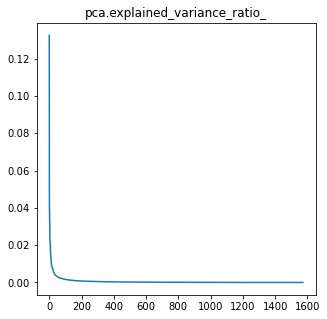

In [13]:
print('PCA and and unsupervised model experimantation')

from sklearn.decomposition import PCA

n_comp = X.shape[1]
# n_comp = 30
clusters = 5

pca = PCA(n_components = n_comp)
X_reduced = pca.fit_transform(X.toarray())
evr = pca.explained_variance_ratio_

plt.figure()
plt.title('pca.explained_variance_ratio_')
plt.plot(evr)
plt.show()


'''models tried '''
from sklearn.mixture import BayesianGaussianMixture 
from sklearn import cluster as cl

model = BayesianGaussianMixture(n_components = clusters,n_init=10) # O(kmn^2+ kn^3) -> slow;  
# model = cl.AffinityPropagation() #did not converge
# model = cl.SpectralClustering(n_clusters=15) # number of distinct clusters (2) found smaller than n_clusters (15). Possibly due to duplicate points in X.
model = cl.AgglomerativeClustering(n_clusters = clusters)
# model = cl.MeanShift()   # Slow


df['test_cat'] = model.fit_predict(X_reduced)

plotting


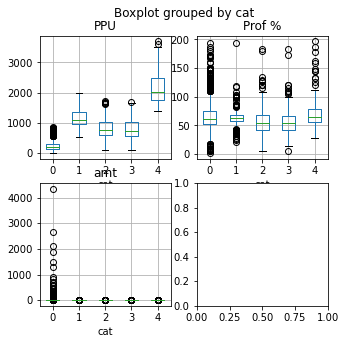

In [14]:
print("plotting")

fig, axes = plt.subplots(nrows=2, ncols=2)

df.boxplot('PPU','cat',ax=axes[0,0])
df.boxplot('Prof %','cat',ax=axes[0,1])
df.boxplot('amt','cat',ax=axes[1,0])

In [15]:
print('Stats by category')
'''TODO:
Plotting by category
'''
# pd.set_option('display.max_rows', df.shape[0]+1)


for i in sorted(df['cat'].unique()):
    frame = df[df['cat']==i]
    print(str(i).center(100))
    print(frame)
#     frame.drop(columns=['name']).plot(title=i)

Stats by category
                                                 0                                                  
                                  name    amt  Prof %   Profit         PPU  cat  test_cat
0              20 Знак нагрудный (№ 9)    5.0  100.00    50.00   10.000000    0         2
1     200 Отл. караул. зн  нагруд. № 7    1.0  117.39    27.00   27.000000    0         2
19                85 лет ВДВ 1930 мед.    1.0   48.65   180.00  180.000000    0         2
20              Multi-банд. dance gold    1.0  103.31   168.96  168.960000    0         2
21               Multi-банд. dig. grey    7.0   50.83   816.20  116.600000    0         2
...                                ...    ...     ...      ...         ...  ...       ...
3143                       Эмблема п/а  256.0   80.28  3420.00   13.359375    0         2
3144           Эмблема УФСИН п/а черн.  100.0   99.88  1997.60   19.976000    0         2
3145                       Якорь 24 мм    8.0  114.29    64.00    8.000

In [9]:
print('Interactive plot, bokeh')
"""
NOTES:
Fix colors?

"""
from bokeh.plotting import figure, show
import bokeh.plotting as bpl
# import bokeh.models as bmo
# from bokeh.palettes import d3
from bokeh.models.tools import HoverTool

source = bpl.ColumnDataSource(df)
hover = HoverTool(tooltips = [('name','@name'),('PPU','@PPU'),('amt','@amt') ])
p = figure(width=1800,height = 1000,tools=[hover])

# use whatever palette you want...
# palette = d3['Category10'][len(df['cat'].unique())]
# color_map = bmo.CategoricalColorMapper(factors = df['cat'].unique().astype('U'),palette=palette)

# create figure and plot
p.scatter('cat','PPU',
#           color={'field': 'cat', 'transform': color_map},
          source=source)

# bpl.show(p) 

Interactive plot, bokeh


GlyphRenderer(id='1025', ...)